In [111]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from src.tools import equatorial_to_cartesian,cartesian_to_equatorial
galaxy_center = "CoM"
# galaxy_center = "N5128,Cen A"
# galaxy_center = "N5236, M83"
galaxy_1 =  "N5128,Cen A"
galaxy_2 =  "N5236, M83"

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# Traitement of data

In [73]:
def parse_galaxy_data(file_path):
    # Define the structure of the data
    columns = [
        ('Name', 1, 16),
        ('RAh', 18, 19),
        ('RAm', 21, 22),
        ('RAs', 24, 27),
        ('DE-', 29, 29),
        ('DEd', 30, 31),
        ('DEm', 33, 34),
        ('DEs', 36, 37),
        ('T', 39, 40),
        ('Theta', 42, 45),
        ('VLG', 47, 49),
        ('e_VLG', 51, 52),
        ('Dis', 54, 57),
        ('e_Dis', 59, 62),
        ('f_Dis', 64, 66),
        ('Ref', 68, 71),
        ('Note', 73, 73)
    ]

    # Read the file and parse the data
    with open(file_path, 'r') as file:
        lines = file.readlines()

    galaxies = []
    for line in lines:
        if line.strip() and not line.startswith('='):
            galaxy_data = {}
            for col_name, start, end in columns:
                value = line[start-1:end].strip()
                galaxy_data[col_name] = value
            galaxies.append(galaxy_data)

    # Convert to DataFrame
    df = pd.DataFrame(galaxies)
    return df



In [114]:
# Example usage
file_path = 'data/data_clean.txt'
galaxy_df = parse_galaxy_data(file_path)
print(galaxy_df)
galaxy_df = galaxy_df[galaxy_df["VLG"] != '']
galaxy_df = galaxy_df[galaxy_df["Dis"] != '']


               Name RAh RAm   RAs DE- DEd DEm DEs   T Theta  VLG e_VLG   Dis  \
0           E059-01  07  31  19.3   -  68  11  10   9  -1.5  245     5  4.57   
1             N2915  09  26  11.5   -  76  37  35  10  -1.3  184     5  3.78   
2        SexB,DDO70  10  00  00.1   +  05  19  56  10  -0.7  111     1  1.36   
3             N3109  10  03  07.2   -  26  09  36   9  -0.1  110     1  1.33   
4     Antlia,P29194  10  04  04.0   -  27  19  55  10   2.3   66     0  1.28   
..              ...  ..  ..   ...  ..  ..  ..  ..  ..   ...  ...   ...   ...   
82          E274-01  15  14  13.5   -  46  48  45   7  -0.8  335     5  3.09   
83  HIPASS J1526-51  15  26  17.0   -  51  10  04            416         5.8   
84          E137-18  16  20  59.3   -  60  29  15   9  -1.8  420     3  6.40   
85    I4662,E102-14  17  47  06.3   -  64  38  25   9  -0.9  145     4  2.44   
86    Tucana,P69519  22  41  49.0   -  64  25  12  -2  -0.1    9     2  0.88   

   e_Dis f_Dis   Ref Note  
0   0.36   

# Calculs

### Conversion of RA-Dec to radians and string to float

In [75]:
def add_radian_columns(df):
    # Convertir RA et Dec en radians et ajouter en tant que nouvelles colonnes
    df['RAh'] = df['RAh'].astype(int)
    df['RAm'] = df['RAm'].astype(int)
    df['RAs'] = df['RAs'].astype(float)
    df['DEd'] = df['DEd'].astype(int)
    df['DEm'] = df['DEm'].astype(int)
    df['DEs'] = df['DEs'].astype(float)

    df['RA_degrees'] = 15 * (df['RAh'] + df['RAm'] / 60 + df['RAs'] / 3600)
    df['RA_radians'] = np.deg2rad(df['RA_degrees'])
    df['RA_radians'] = pd.to_numeric(df['RA_radians'], errors='coerce')


    df['Dec_degrees'] = df['DEd'] + df['DEm'] / 60 + df['DEs'] / 3600
    df['Dec_degrees'] = df.apply(lambda row: -row['Dec_degrees'] if row['DE-'] == '-' else row['Dec_degrees'], axis=1)
    df['Dec_radians'] = np.deg2rad(df['Dec_degrees'])

    df['Dis'] = pd.to_numeric(df['Dis'], errors='coerce')
    df['e_Dis'] = pd.to_numeric(df['e_Dis'], errors='coerce')
    df['VLG'] = pd.to_numeric(df['VLG'], errors='coerce')
    df['e_VLG'] = pd.to_numeric(df['e_VLG'], errors='coerce')


In [76]:
# Example usage
add_radian_columns(galaxy_df)
data_clean = galaxy_df.dropna(subset=['VLG'])
data_clean = galaxy_df.dropna(subset=['Dis'])
print(galaxy_df['VLG'])
galaxy_df.to_csv("test.csv")

0     245
1     184
2     111
3     110
4      66
     ... 
82    335
83    416
84    420
85    145
86      9
Name: VLG, Length: 70, dtype: int64


In [77]:
column="RA_degrees"
print(type(galaxy_df[column][85]))
print(galaxy_df[column][85])
print(galaxy_df.columns)

<class 'numpy.float64'>
266.77625000000006
Index(['Name', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'T', 'Theta',
       'VLG', 'e_VLG', 'Dis', 'e_Dis', 'f_Dis', 'Ref', 'Note', 'RA_degrees',
       'RA_radians', 'Dec_degrees', 'Dec_radians'],
      dtype='object')


In [78]:
def add_CoM(df,galaxy1,galaxy2,m1_barre):
    m2_barre = 1- m1_barre
    d1, ra1, dec1, v1 = float(df.loc[df["Name"]==galaxy1,"Dis"].iloc[0]), float(df.loc[df["Name"]==galaxy1,"RA_radians"].iloc[0]), float(df.loc[df["Name"]==galaxy1,"Dec_radians"].iloc[0]), float(df.loc[df["Name"]==galaxy1,"VLG"].iloc[0])
    
    d2, ra2, dec2, v2 = float(df.loc[df["Name"]==galaxy2,"Dis"].iloc[0]), float(df.loc[df["Name"]==galaxy2,"RA_radians"].iloc[0]), float(df.loc[df["Name"]==galaxy2,"Dec_radians"].iloc[0]), float(df.loc[df["Name"]==galaxy2,"VLG"].iloc[0])
    r1 = equatorial_to_cartesian(d1,ra1,dec1)
    r2 = equatorial_to_cartesian(d2,ra2,dec2)
    rc = m1_barre*r1 + m2_barre*r2
    new_coord = cartesian_to_equatorial(rc[0],rc[1],rc[2])
    
    V1 = equatorial_to_cartesian(v1,ra1,dec1)
    V2 = equatorial_to_cartesian(v2,ra2,dec2)
    Vc = m1_barre*V1 + m2_barre*V2
    
    
    # Attention:  the new velocity is not necesseraly radial
    new_Rad_velocity = np.dot(Vc,rc)/ np.linalg.norm(rc)
    
    if not df['Name'].isin(["CoM"]).any():
        new_row = {'Name' :"CoM", 'RAh':None, 'RAm':None, 'RAs':None, 'DE-':None, 'DEd':None, 'DEm':None, 'DEs':None, 'T':None, 'Theta':None, 'VLG':new_Rad_velocity, 'e_VLG':None, 'Dis':new_coord[0], 'e_Dis':None, 'f_Dis':None, 'Ref':None, 'Note':None, 'RA_degrees':None, 'RA_radians':new_coord[1], 'Dec_degrees':None, 'Dec_radians': new_coord[2]}    
        df.loc[len(df)] = new_row
    else:
        df.loc[df['Name'] == 'CoM', 'Dis' ] = new_coord[0]
        df.loc[df['Name'] == 'CoM', 'VLG' ] = new_Rad_velocity
        df.loc[df['Name'] == 'CoM', 'RA_radians' ] = new_coord[1]
        df.loc[df['Name'] == 'CoM', 'Dec_radians' ] = new_coord[2]
        
    
        

In [79]:
add_CoM(galaxy_df,galaxy1="N5128,Cen A",galaxy2="N5236, M83",m1_barre=0)
galaxy_df.to_csv("test.csv")

C:\Users\Adrian\AppData\Local\Temp\ipykernel_12564\2552546843.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '304.00000000000006' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[len(df)] = new_row


### Calculation of Angular ditances

In [80]:
def add_angular_distance(df,galaxy_center="N5128,Cen A"):
    ra_center= float(df.loc[df["Name"]==galaxy_center,"RA_radians"].iloc[0])
    dec_center = float(df.loc[df["Name"] == galaxy_center, "Dec_radians"].iloc[0])
    # Calculer les composantes trigonométriques
    sin_dec_1 = np.sin(dec_center)
    sin_dec_2 = np.sin(df['Dec_radians'])
    cos_dec_1 = np.cos(dec_center)
    cos_dec_2 = np.cos(df['Dec_radians'])
    cos_ra_diff = np.cos(ra_center - df['RA_radians'])
    # Calculer cos(θ)
    cos_theta = sin_dec_1 * sin_dec_2 + cos_dec_1 * cos_dec_2 * cos_ra_diff
    # Ajouter la colonne au DataFrame
    df["cos_theta"]= cos_theta
    df['angular_distance'] = np.arccos(cos_theta)




In [81]:
add_angular_distance(galaxy_df,galaxy_center=galaxy_center)
print(galaxy_df["angular_distance"])
print(galaxy_df["cos_theta"])

0     1.099147
1     0.956379
2     1.094854
3     0.819125
4     0.809641
        ...   
82    0.441807
83    0.513486
84    0.713923
85    0.900317
86    1.390899
Name: angular_distance, Length: 70, dtype: float64
0     0.454356
1     0.576483
2     0.458176
3     0.682861
4     0.689759
        ...   
82    0.903981
83    0.871037
84    0.755799
85    0.621362
86    0.178928
Name: cos_theta, Length: 70, dtype: float64


In [82]:
print(galaxy_df["Name"][51])
print(f"Angular distance between CenA and CenA is {galaxy_df["angular_distance"][42]*(180/np.pi)}°")
print(f"Angular distance between CenA and M83 is {galaxy_df["angular_distance"][51]*(180/np.pi)}°")
# print(galaxy_df["cos_theta"][51])

N5236, M83
Angular distance between CenA and CenA is 13.349094196198603°
Angular distance between CenA and M83 is 0.0°


### Calculation of Distances

In [83]:
def add_distances(df,galaxy_center="N5128,Cen A"):
    distance_center= float(df.loc[df["Name"]==galaxy_center,"Dis"].iloc[0])
    # Calculer distance
    dis_center = np.square(df['Dis']) + np.square(distance_center) - 2 * distance_center * df["Dis"] * df["cos_theta"]
    # Ajouter la colonne au DataFrame
    df['dis_center'] = np.sqrt(dis_center)

In [84]:
add_distances(galaxy_df,galaxy_center)
#print(galaxy_df["dis_center"])
print(f"Distance between CenA and Cen A is {galaxy_df["dis_center"][42]} Mpc")
print(f"Distance between CenA and M83 is {galaxy_df["dis_center"][51]} Mpc")

Distance between CenA and Cen A is 1.727222222845604 Mpc
Distance between CenA and M83 is 0.0 Mpc


### Calculation of Infall Velocities

In [85]:
def add_minor_infall_velocity(df,galaxy_center="N5128,Cen A"):
    distance_center= float(df.loc[df["Name"]==galaxy_center,"Dis"].iloc[0])
    velocity_center = float(df.loc[df["Name"]==galaxy_center,"VLG"].iloc[0])
    
    ## fonction to calculate minor velocities
    def calculate_minor_infall(row):
        rg, vg, cos_theta, rgcenter = row['Dis'], row['VLG'], row['cos_theta'], row['dis_center']

        if rgcenter == 0:
            return 0  # prevent zero division

        numerator = (velocity_center * distance_center + vg * rg) - cos_theta* (vg * distance_center + velocity_center * rg)
        return numerator / rgcenter

    # caculate minor_infall_velocities Ajouter la colonne au DataFrame
    df['minor_infall_velocity'] = df.apply(calculate_minor_infall, axis=1)

def add_major_infall_velocity(df,galaxy_center="N5128,Cen A"):
    distance_center= float(df.loc[df["Name"]==galaxy_center,"Dis"].iloc[0])
    velocity_center = float(df.loc[df["Name"]==galaxy_center,"VLG"].iloc[0])
    
    ## fonction to calculate minor velocities
    def calculate_major_infall(row):
        rg, vg, cos_theta, rgcenter = row['Dis'], row['VLG'], row['cos_theta'], row['dis_center']
        numerator = vg - velocity_center * cos_theta
        denominator = rg - distance_center * cos_theta

        # Éviter la division par zéro
        if denominator == 0:
            return 0

        return (numerator / denominator) * rgcenter

    # caculate minor_infall_velocities Ajouter la colonne au DataFrame
    df['major_infall_velocity'] = df.apply(calculate_major_infall, axis=1)
    
def add_major_infall_velocity_bis(df,galaxy_center="N5128,Cen A"):
    distance_center= float(df.loc[df["Name"]==galaxy_center,"Dis"].iloc[0])
    velocity_center = float(df.loc[df["Name"]==galaxy_center,"VLG"].iloc[0])
    
    ## fonction to calculate minor velocities
    def calculate_major_infall_bis(row):
        rg, vg, cos_theta, rgcenter = row['Dis'], row['VLG'], row['cos_theta'], row['dis_center']
        numerator = velocity_center - vg * cos_theta
        denominator =  distance_center - rg * cos_theta

        # Éviter la division par zéro
        if denominator == 0:
            return 0

        return (numerator / denominator) * rgcenter

    # caculate minor_infall_velocities Ajouter la colonne au DataFrame
    df['major_infall_velocity_bis'] = df.apply(calculate_major_infall_bis, axis=1)

In [86]:
add_minor_infall_velocity(galaxy_df,galaxy_center=galaxy_center)
print(galaxy_df["minor_infall_velocity"])
print(f"Minor infall velocity of CenA regarding CenA is {galaxy_df["minor_infall_velocity"][42]} km/s")
print(f"Minor infall velocity of M83 regarding CenA is {galaxy_df["minor_infall_velocity"][51]} km/s")

0     290.317322
1     245.631672
2     270.010934
3     241.035815
4     262.733375
         ...    
82     70.837628
83    201.989618
84    273.172677
85    242.198813
86    299.470112
Name: minor_infall_velocity, Length: 70, dtype: float64
Minor infall velocity of CenA regarding CenA is 44.637971371442205 km/s
Minor infall velocity of M83 regarding CenA is 0.0 km/s


In [87]:
add_major_infall_velocity(galaxy_df,galaxy_center=galaxy_center)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
print(galaxy_df["major_infall_velocity"])

print(f"Major infall velocity of CenA regarding CenA is {galaxy_df["major_infall_velocity"][42]} km/s")
print(f"Major infall velocity of M83 regarding CenA is {galaxy_df["major_infall_velocity"][51]} km/s")

0      245.254835
1       46.633389
2      132.251283
3      194.035018
4      275.902768
         ...     
82    -103.614404
83     330.231724
84     319.829157
85     235.728594
86    5326.275789
Name: major_infall_velocity, Length: 70, dtype: float64
Major infall velocity of CenA regarding CenA is -7.200749176844712 km/s
Major infall velocity of M83 regarding CenA is -0.0 km/s


In [88]:
add_major_infall_velocity_bis(galaxy_df,galaxy_center=galaxy_center)
print(galaxy_df["major_infall_velocity_bis"])
print(f"Major bis infall velocity of CenA regarding CenA is {galaxy_df["major_infall_velocity_bis"][42]} km/s")
print(f"Major bis infall velocity of M83 regarding CenA is {galaxy_df["major_infall_velocity_bis"][51]} km/s")

0      319.121583
1      285.016480
2      261.974399
3      234.785751
4      264.474177
         ...     
82       1.335938
83   -1540.655663
84    -174.898621
85     241.555457
86     306.885094
Name: major_infall_velocity_bis, Length: 70, dtype: float64
Major bis infall velocity of CenA regarding CenA is 12.888925181286123 km/s
Major bis infall velocity of M83 regarding CenA is -0.0 km/s


In [89]:
#save the dataframe
galaxy_df.to_csv("galaxy_data.csv", index=False, encoding='utf-8')

In [90]:
print(galaxy_df.loc[galaxy_df["Name"]=="KKs51"])

Empty DataFrame
Columns: [Name, RAh, RAm, RAs, DE-, DEd, DEm, DEs, T, Theta, VLG, e_VLG, Dis, e_Dis, f_Dis, Ref, Note, RA_degrees, RA_radians, Dec_degrees, Dec_radians, cos_theta, angular_distance, dis_center, minor_infall_velocity, major_infall_velocity, major_infall_velocity_bis]
Index: []


In [91]:
def procedure_CoM(df,galaxy1,galaxy2, r):
    add_CoM(df,galaxy1,galaxy2,r)
    add_angular_distance(df,galaxy_center="CoM")
    add_distances(df,galaxy_center="CoM")
    add_major_infall_velocity(df,galaxy_center="CoM")
    add_minor_infall_velocity(df,galaxy_center="CoM")
    add_major_infall_velocity_bis(df,galaxy_center="CoM")

In [92]:
procedure_CoM(galaxy_df,galaxy1=galaxy_1,galaxy2=galaxy_2,r=0.76)


In [107]:
def mean_square_peculiar_velocity(df,velocity):
    return (df[velocity] ** 2).mean()

# Affichage


### distance/velocity from Milky way

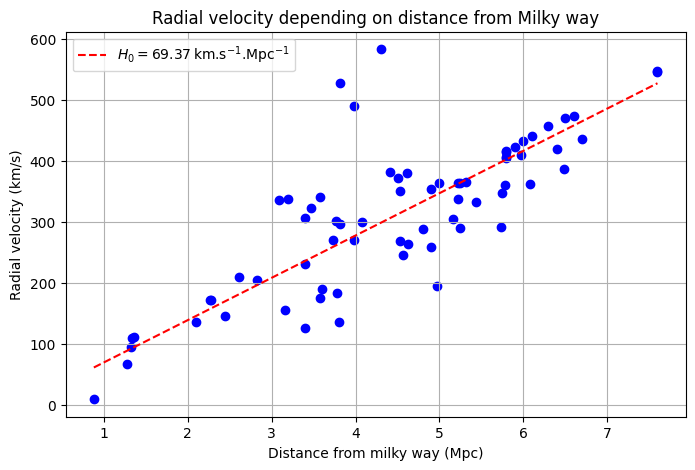

In [93]:
plt.figure(figsize=(8, 5))
plt.scatter(galaxy_df['Dis'], galaxy_df['VLG'], color='b')



# Linear regression
x = galaxy_df['Dis'].values
y = galaxy_df['VLG'].values


A = x.reshape(-1, 1)  # Mise en forme pour lstsq
a, _, _, _ = np.linalg.lstsq(A, y, rcond=None)  # Résolution du système

# Calcul du R²
y_pred = a * x  # y = ax, pas de b
SS_res = np.sum((y - y_pred) ** 2)  # Somme des carrés des résidus
SS_tot = np.sum((y - np.mean(y)) ** 2)  # Somme totale des carrés
R2 = 1 - (SS_res / SS_tot)  # Coefficient de détermination


# Tracé de la droite de régression
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = a * x_vals  # Pas de b
plt.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a[0]:.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")


# Affichage
plt.xlabel("Distance from milky way (Mpc)")
plt.ylabel(r"Radial velocity (km/s)")
plt.title("Radial velocity depending on distance from Milky way")
plt.legend()
plt.grid(True)
plt.show()

### Distance/Velocity from CenA

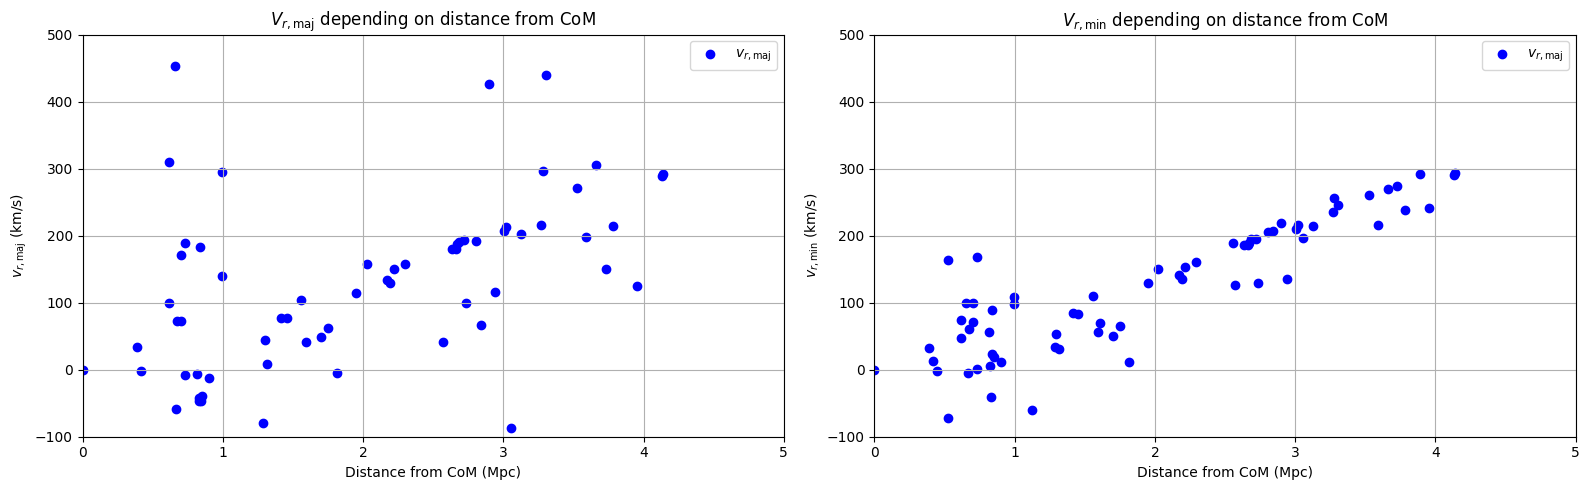

In [ ]:
mass_ratio = 0.76
procedure_CoM(galaxy_df,galaxy1=galaxy_1,galaxy2=galaxy_2,r=mass_ratio)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Graphique pour v_{r,\text{maj}}
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$') # Tracé des points
ax1.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax1.set_ylabel(r"$v_{r,\text{maj}}$ (km/s)")
ax1.set_title(r"$V_{r,\text{maj}}$ depending on distance from "+galaxy_center)
ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, 5)  # Limites de l'axe x entre 1 et 5
ax1.set_ylim(-100, 500)  # Limites de l'axe y entre -25 et 20
# Graphique pour v_{r,\text{min}}
ax2.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$')  # Tracé des points

ax2.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax2.set_ylabel(r"$v_{r,\text{min}}$ (km/s)")
ax2.set_title(r"$V_{r,\text{min}}$ depending on distance from "+galaxy_center)
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)


plt.tight_layout()


plt.show()


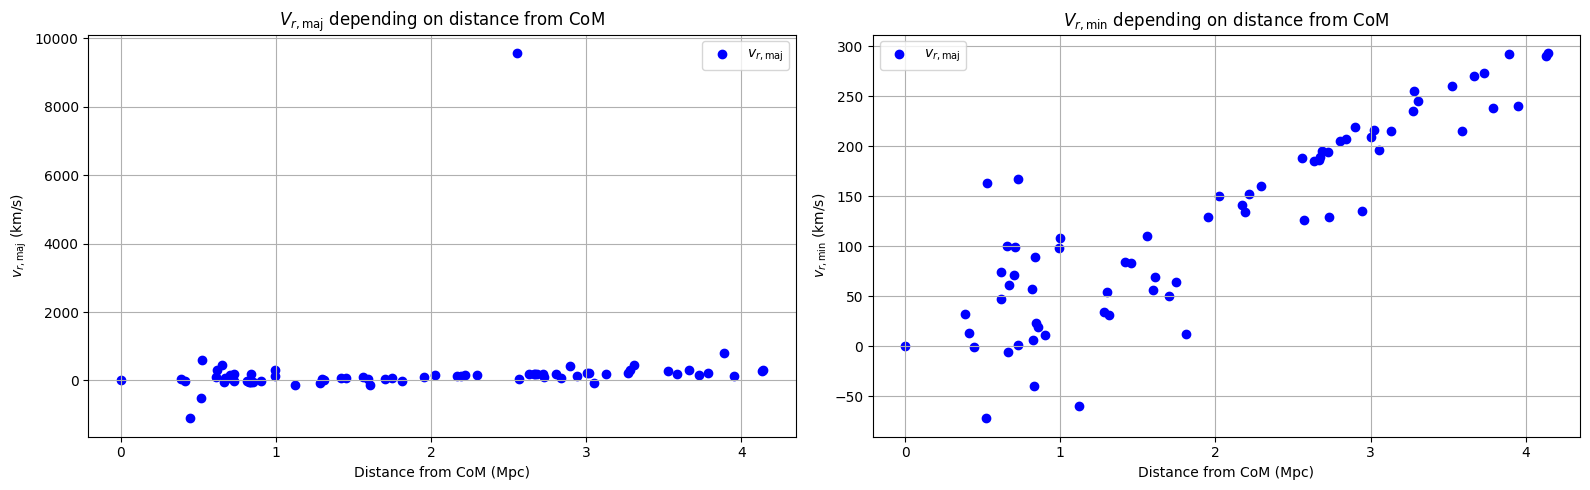

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Graphique pour v_{r,\text{maj}}
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$') 
ax1.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax1.set_ylabel(r"$v_{r,\text{maj}}$ (km/s)")
ax1.set_title(r"$V_{r,\text{maj}}$ depending on distance from "+galaxy_center)
ax1.legend()
ax1.grid(True)

# Graphique pour v_{r,\text{min}}
ax2.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$')  

ax2.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax2.set_ylabel(r"$v_{r,\text{min}}$ (km/s)")
ax2.set_title(r"$V_{r,\text{min}}$ depending on distance from "+galaxy_center)
ax2.legend()
ax2.grid(True)



plt.tight_layout()


plt.show()

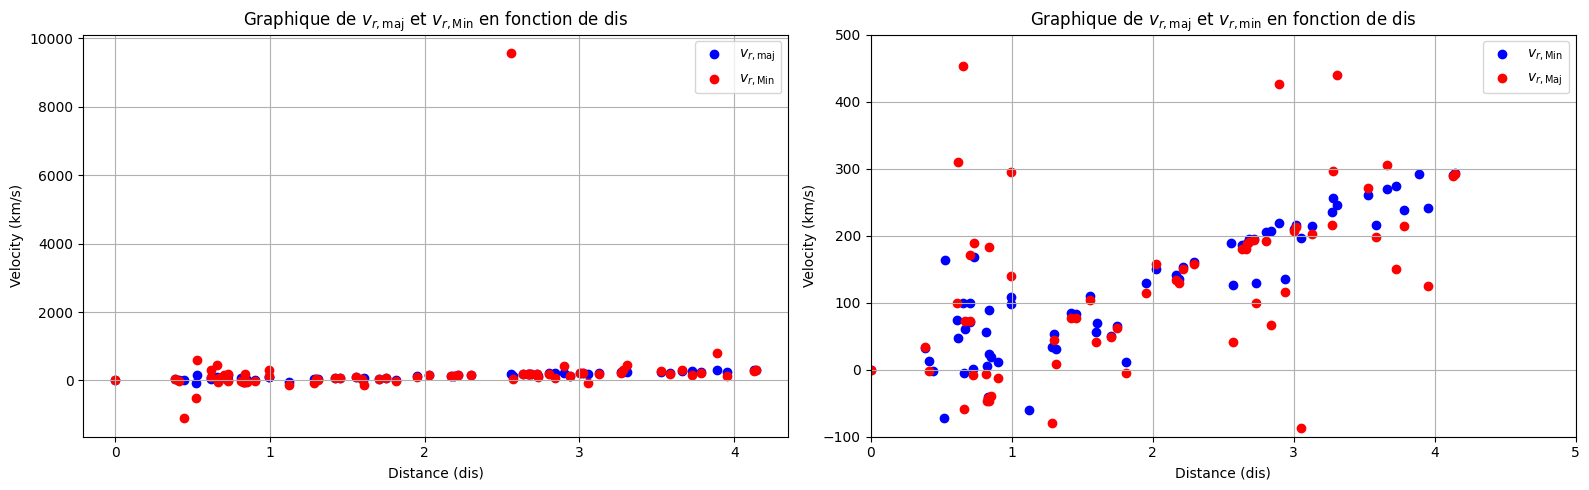

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes
ax1.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$')
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='r', label=r'$v_{r,\text{Min}}$') 

# Ajout de titres et labels
ax1.set_xlabel("Distance (dis)")
ax1.set_ylabel(r"Velocity (km/s)")
ax1.set_title(r"Graphique de $v_{r,\text{maj}}$ et $v_{r,\text{Min}}$ en fonction de dis")
ax1.legend()
ax1.grid(True)

ax2.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], color='b', label=r'$v_{r,\text{Min}}$')
ax2.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='r', label=r'$v_{r,\text{Maj}}$') 

# Ajout de titres et labels
ax2.set_xlabel("Distance (dis)")
ax2.set_ylabel(r"Velocity (km/s)")
ax2.set_title(r"Graphique de $v_{r,\text{maj}}$ et $v_{r,\text{min}}$ en fonction de dis")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)


plt.tight_layout()


plt.show()

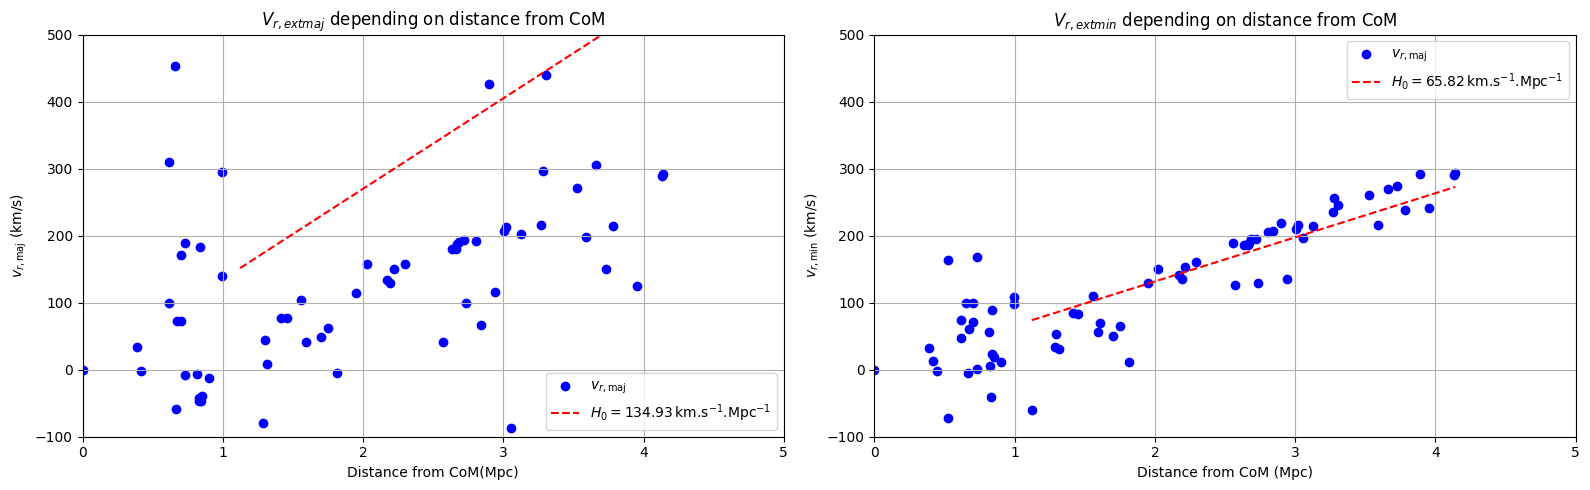

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Graphique pour v_{r,\text{maj}}
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$') # Tracé des points
ax1.set_xlabel("Distance from "+ galaxy_center+ "(Mpc)")
ax1.set_ylabel(r"$v_{r,\text{maj}}$ (km/s)")
ax1.set_title("$V_{r,\text{maj}}$ depending on distance from "+galaxy_center)

# Graphique pour v_{r,\text{min}}
ax2.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$')  # Tracé des points

ax2.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax2.set_ylabel(r"$v_{r,\text{min}}$ (km/s)")
ax2.set_title("$V_{r,\text{min}}$ depending on distance from "+galaxy_center)
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)



# Linear regression 1 
x = galaxy_df[galaxy_df["dis_center"] >= 1]['dis_center'].values
y = galaxy_df[galaxy_df["dis_center"] >= 1]['major_infall_velocity'].values

A = x.reshape(-1, 1)  # Mise en forme pour lstsq
a, _, _, _ = np.linalg.lstsq(A, y, rcond=None)  # Résolution du système

# Tracé de la droite de régression
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = a * x_vals  # Pas de b
ax1.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a[0]:.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, 5)  # Limites de l'axe x entre 1 et 5
ax1.set_ylim(-100, 500)  # Limites de l'axe y entre -25 et 20

# Linear regression 1 
x = galaxy_df[galaxy_df["dis_center"] >= 1]['dis_center'].values
y = galaxy_df[galaxy_df["dis_center"] >= 1]['minor_infall_velocity'].values

A = x.reshape(-1, 1)  # Mise en forme pour lstsq
a, _, _, _ = np.linalg.lstsq(A, y, rcond=None)  # Résolution du système

# Tracé de la droite de régression
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = a * x_vals  # Pas de b
ax2.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a[0]:.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)


# Affichage
plt.tight_layout()
plt.show()

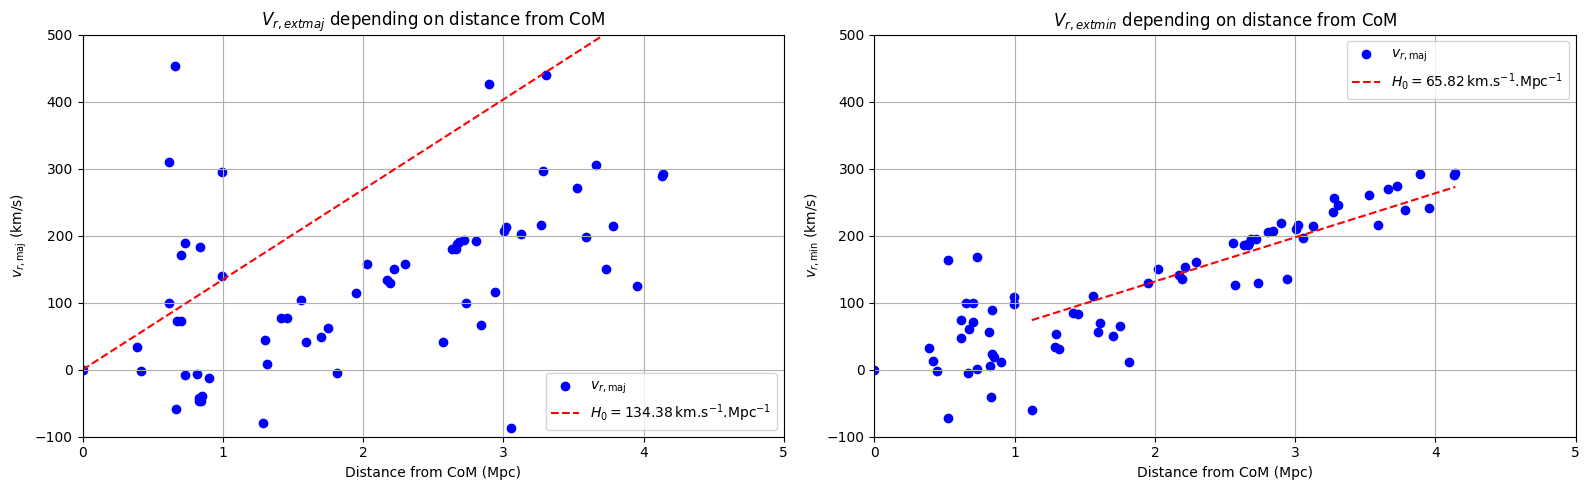

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Graphique pour v_{r,\text{maj}}
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$') # Tracé des points
ax1.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax1.set_ylabel(r"$v_{r,\text{maj}}$ (km/s)")
ax1.set_title("$V_{r,\text{maj}}$ depending on distance from "+galaxy_center)

# Graphique pour v_{r,\text{min}}
ax2.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], color='b', label=r'$v_{r,\text{maj}}$')  # Tracé des points

ax2.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax2.set_ylabel(r"$v_{r,\text{min}}$ (km/s)")
ax2.set_title("$V_{r,\text{min}}$ depending on distance from "+galaxy_center)
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)



# Linear regression 1 
x = galaxy_df[(galaxy_df["Dis"] >= 1) & (galaxy_df["major_infall_velocity"] > -100)]['dis_center'].values
y = galaxy_df[(galaxy_df["Dis"] >= 1) & (galaxy_df["major_infall_velocity"] > -100)]['major_infall_velocity'].values

A = x.reshape(-1, 1)  # Mise en forme pour lstsq
a, _, _, _ = np.linalg.lstsq(A, y, rcond=None)  # Résolution du système

# Tracé de la droite de régression
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = a * x_vals  # Pas de b
ax1.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a[0]:.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
ax1.legend()
ax1.grid(True)
ax1.set_xlim(0, 5)  # Limites de l'axe x entre 1 et 5
ax1.set_ylim(-100, 500)  # Limites de l'axe y entre -25 et 20

# Linear regression 1 
x = galaxy_df[galaxy_df["dis_center"] >= 1]['dis_center'].values
y = galaxy_df[galaxy_df["dis_center"] >= 1]['minor_infall_velocity'].values

A = x.reshape(-1, 1)  # Mise en forme pour lstsq
a, _, _, _ = np.linalg.lstsq(A, y, rcond=None)  # Résolution du système

# Tracé de la droite de régression
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = a * x_vals  # Pas de b
ax2.plot(x_vals, y_vals, 'r--', label=f"$H_0 = {a[0]:.2f}\\, \\text{{km.s}}^{{-1}}\\text{{.Mpc}}^{{-1}}$")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)


# Affichage
plt.tight_layout()
plt.show()

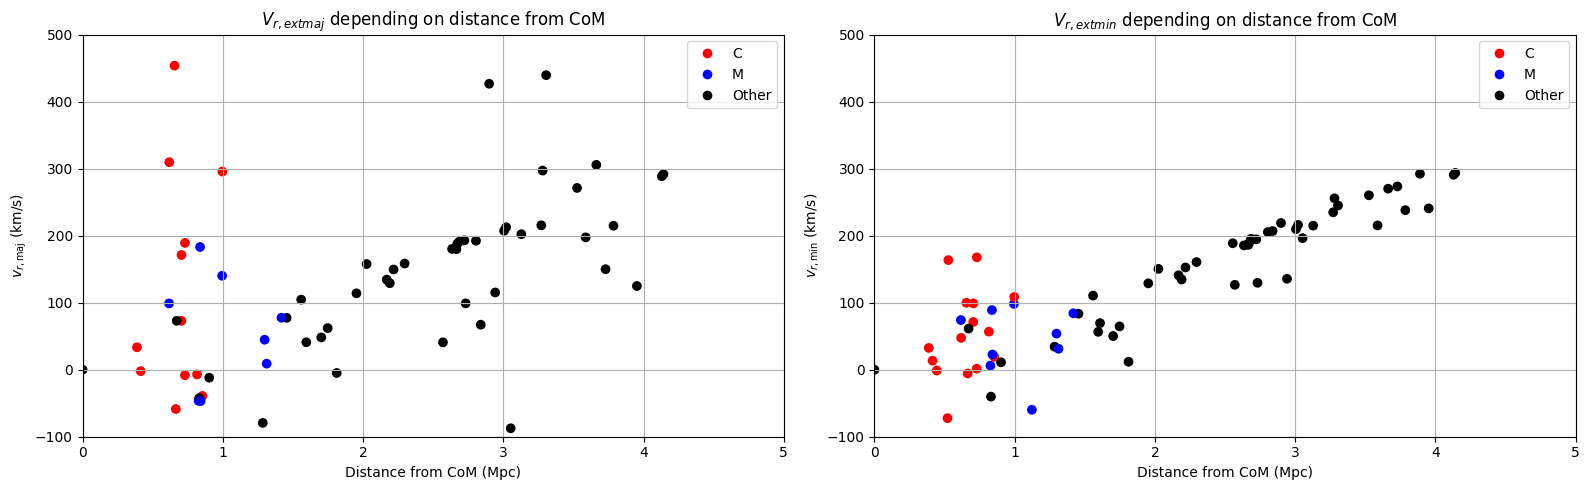

In [99]:
color_map = {"C": "red", "M": "blue"}  # C en rouge, M en bleu
galaxy_df["color"] = galaxy_df["Note"].map(color_map).fillna("black")  # Les autres en noir

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Graphique pour v_{r,\text{maj}}
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], 
            color=galaxy_df["color"], label=r'$v_{r,\text{maj}}$')  # Tracé des points
ax1.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax1.set_ylabel(r"$v_{r,\text{maj}}$ (km/s)")
ax1.set_title("$V_{r,\text{maj}}$ depending on distance from "+galaxy_center)
ax1.grid(True)
ax1.set_xlim(0, 5)
ax1.set_ylim(-100, 500)

# Graphique pour v_{r,\text{min}}
ax2.scatter(galaxy_df['dis_center'], galaxy_df['minor_infall_velocity'], 
            color=galaxy_df["color"], label=r'$v_{r,\text{min}}$')  # Tracé des points
ax2.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax2.set_ylabel(r"$v_{r,\text{min}}$ (km/s)")
ax2.set_title("$V_{r,\text{min}}$ depending on distance from "+galaxy_center)
ax2.grid(True)
ax2.set_xlim(0, 5)
ax2.set_ylim(-100, 500)

# Ajout d'une légende manuelle
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='C', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='M', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='black', markersize=8)
]
ax1.legend(handles=legend_elements, loc="upper right")
ax2.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()


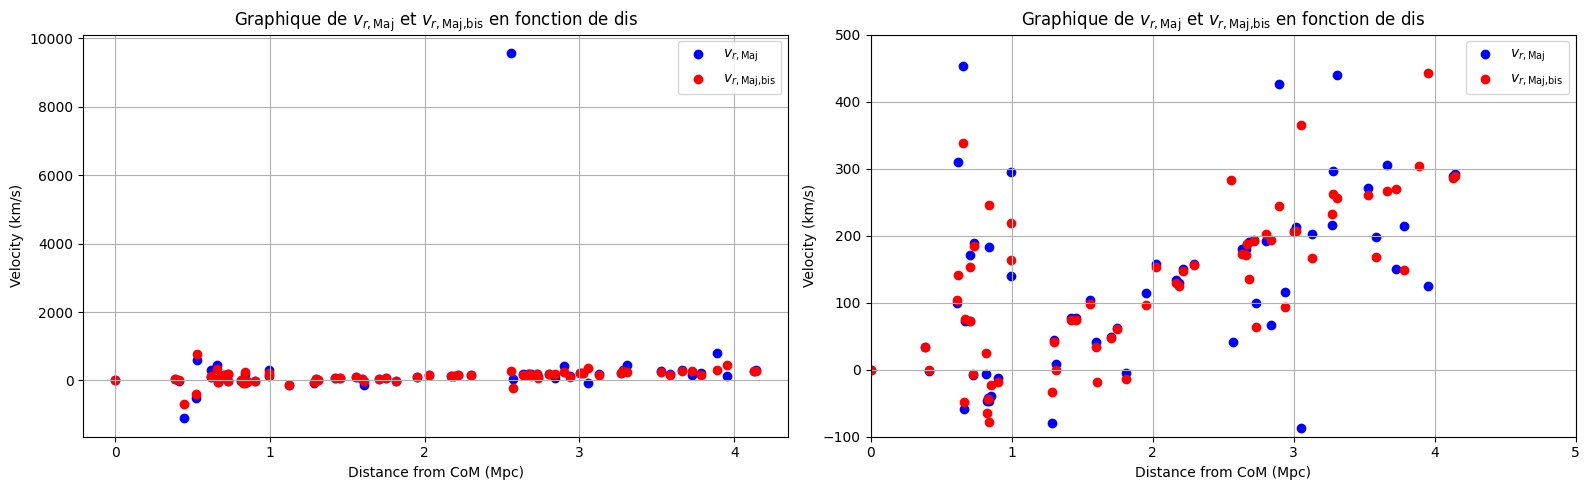

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='b', label=r'$v_{r,\text{Maj}}$')
ax1.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity_bis'], color='r', label=r'$v_{r,\text{Maj,bis}}$') 

# Ajout de titres et labels
ax1.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax1.set_ylabel(r"Velocity (km/s)")
ax1.set_title(r"Graphique de $v_{r,\text{Maj}}$ et $v_{r,\text{Maj,bis}}$ en fonction de dis")
ax1.legend()
ax1.grid(True)

ax2.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity'], color='b', label=r'$v_{r,\text{Maj}}$')
ax2.scatter(galaxy_df['dis_center'], galaxy_df['major_infall_velocity_bis'], color='r', label=r'$v_{r,\text{Maj,bis}}$') 

# Ajout de titres et labels
ax2.set_xlabel("Distance from "+galaxy_center+" (Mpc)")
ax2.set_ylabel(r"Velocity (km/s)")
ax2.set_title(r"Graphique de $v_{r,\text{Maj}}$ et $v_{r,\text{Maj,bis}}$ en fonction de dis")
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0, 5)  
ax2.set_ylim(-100, 500)


plt.tight_layout()


plt.show()

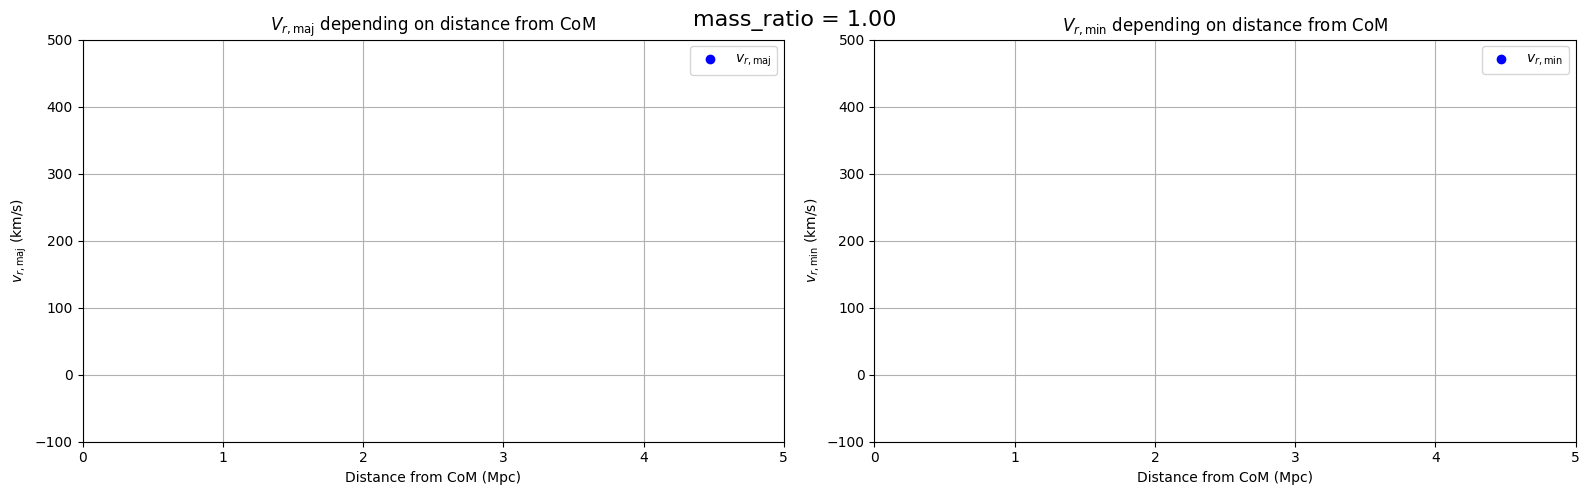

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plots initiaux (vides pour l'instant)
sc1 = ax1.scatter([], [], color='b', label=r'$v_{r,\text{maj}}$')
sc2 = ax2.scatter([], [], color='b', label=r'$v_{r,\text{min}}$')

# Configuration des axes
for ax in [ax1, ax2]:
    ax.set_xlim(0, 5)
    ax.set_ylim(-100, 500)
    ax.grid(True)

ax1.set_xlabel("Distance from " + galaxy_center + " (Mpc)")
ax1.set_ylabel(r"$v_{r,\text{maj}}$ (km/s)")
ax1.set_title(r"$V_{r,\text{maj}}$ depending on distance from " + galaxy_center)
ax1.legend()

ax2.set_xlabel("Distance from " + galaxy_center + " (Mpc)")
ax2.set_ylabel(r"$v_{r,\text{min}}$ (km/s)")
ax2.set_title(r"$V_{r,\text{min}}$ depending on distance from " + galaxy_center)
ax2.legend()

# Fonction d'initialisation
def init():
    sc1.set_offsets(np.empty((0, 2)))
    sc2.set_offsets(np.empty((0, 2)))
    return sc1, sc2

# Fonction de mise à jour pour chaque frame
def update(frame):
    mass_ratio = frame
    procedure_CoM(galaxy_df, galaxy1=galaxy_1, galaxy2=galaxy_2, r=mass_ratio)

    # On récupère les coordonnées x et y mises à jour
    x = galaxy_df['dis_center'].values
    y1 = galaxy_df['major_infall_velocity'].values
    y2 = galaxy_df['minor_infall_velocity'].values

    # On met à jour les scatter plots
    sc1.set_offsets(np.column_stack((x, y1)))
    sc2.set_offsets(np.column_stack((x, y2)))

    fig.suptitle(f"mass_ratio = {mass_ratio:.2f}", fontsize=16)
    return sc1, sc2

# Création des frames (valeurs de mass_ratio de 0 à 1)
mass_ratios = np.linspace(0, 1, 50)

# Création de l'animation
ani = FuncAnimation(fig, update, frames=mass_ratios, init_func=init, blit=False, interval=100)

plt.tight_layout()
HTML(ani.to_jshtml())  # Affiche l'animation directement dans le notebook

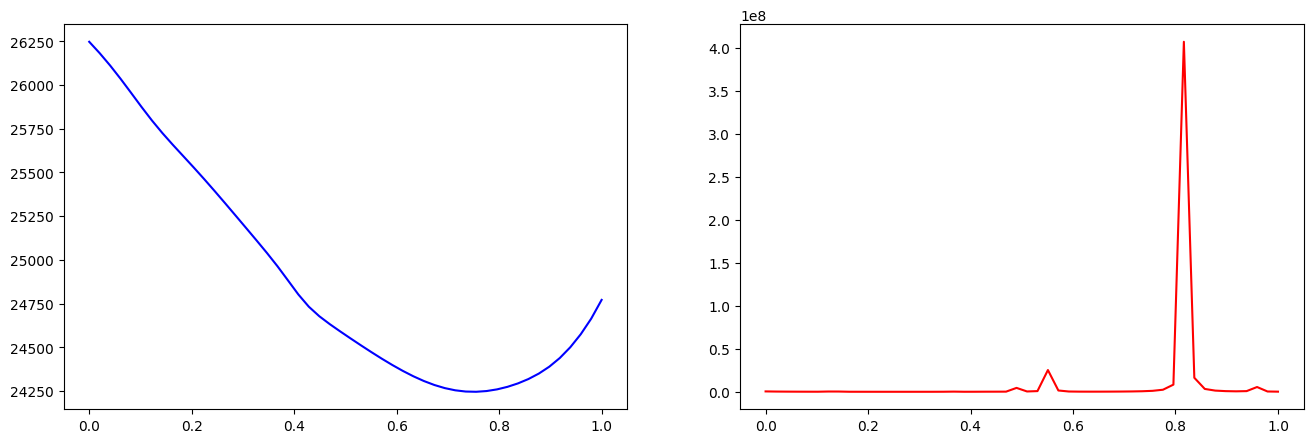

In [110]:
mass_ratios = np.linspace(0, 1, 50)
mean_square_value_minor = [0 for r in mass_ratios]
mean_square_value_major = [0 for r in mass_ratios]
for k in range(0,len(mass_ratios)):
    procedure_CoM(galaxy_df,galaxy1=galaxy_1,galaxy2=galaxy_2,r=mass_ratios[k])
    mean_square_value_major[k] = mean_square_peculiar_velocity(galaxy_df,"major_infall_velocity")
    mean_square_value_minor[k] = mean_square_peculiar_velocity(galaxy_df,"minor_infall_velocity")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes
ax1.plot(mass_ratios, mean_square_value_minor, color='b', label=r'$v_{r,\text{Maj}}$')
ax2.plot(mass_ratios, mean_square_value_major, color='r', label=r'$v_{r,\text{Maj,bis}}$') 
plt.show()